# DAS Data Compression using Autoencoder

This notebook shows how to do lossy DAS data compression using neural networks (Autoencoder). The original code is from [TensorFlow Compression](https://github.com/tensorflow/compression).

## Paper and posts for understanding related theories

1. [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)
2. [Image Compression Using Autoencoders in Keras](https://blog.paperspace.com/autoencoder-image-compression-keras/)
3. [AI-Based Image Compression: The State of the Art](https://towardsdatascience.com/ai-based-image-compression-the-state-of-the-art-fb5aa6042bfa)

## Setup

Install Tensorflow Compression via `pip`.

In [98]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import library dependencies.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

plt.rcParams.update({'font.size': 14})

In [71]:
import sys
print(sys.version)
print(tf.__version__)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
2.12.0


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [72]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


def make_synthesis_transform(patch_size):
  """Creates the synthesis (decoder) transform."""
  if (patch_size // 4) * 4 != patch_size:
    raise ValueError('patch_size must be dividable ny 4!')

  return tf.keras.Sequential([
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(50 * (patch_size//4)**2, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((patch_size//4, patch_size//4, 50)),
      tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original data patch and their reconstructions.


In [73]:
class DASCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for DAS data."""

  def __init__(self, latent_dims, patch_size):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform(patch_size)
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).

    # Note: since x is devided by 255, we need mutiply the 
    # original data by 255 to keep consistency in data preparation
    x = tf.cast(x, self.compute_dtype) / 255.

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


Train the model.
We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter  𝜆 .

This loss function affects the different parts of the model differently:

The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
The synthesis transform is trained to minimize distortion, given the latent representation.
The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [74]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x


def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)


def train_das_model(training_dataset,    # training dataset
                    validation_dataset,  # validation dataset
                    lmbda=2000,          # weight for rate–distortion Lagrangian
                    latent_dims=50,      # layers in latent space
                    patch_size = 28,     # patch size of the image, must be dividable by 4
                    epochs=15,           # epoch
                    batch_size=128,      # batch size
                    learning_rate=1e-3,  # learning rate
                    validation_freq=1,   # validation freq
                    ):

  trainer = DASCompressionTrainer(latent_dims, patch_size)
  trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      # Just pass through rate and distortion as losses/metrics.
      loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
      metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
      loss_weights=dict(rate=1., distortion=lmbda),)

  history = trainer.fit(training_dataset.map(add_rd_targets).batch(batch_size).prefetch(8),
      epochs=epochs,
      validation_data=validation_dataset.map(add_rd_targets).batch(batch_size).cache(),
      validation_freq=validation_freq,
      verbose=1,)

  return trainer, history

## Tools for preparing DAS data

In [80]:
def add_noise_per_patch(image_patch, snr):
    ''' Add Gaussian noise to the original DAS patch based on the value of snr
    '''
    # compute the power
    signal_power = np.mean(image_patch ** 2)
    noise_power = signal_power / snr

    # Generate Gaussian noise with zero mean and noise_power standard deviation
    noise = np.random.normal(loc=0, scale=np.sqrt(noise_power), size=image_patch.shape)
    noisy_patch = np.zeros_like(image_patch)
    noisy_patch = noisy_patch + noise

    return noisy_patch



def extract_image_patches(DAS_data, patch_size, add_noise = False, snr = 0.5, overlap = False):
  ''' Divide the DAS data (channels by time samples) into small
      patches with the size of patch_size

        Parameters
        ----------
        DAS_data : numpy array (channels by time samples)
        patch_size : int, size of the patch
        add_noise : 
        snr : Signal-to-noise ratio
        
        Returns
        -------
        patches : list of patches
        factors : list of factors used in patch normalization
  '''

  # get the shape
  height, width, = DAS_data.shape

  # create empty list
  input_patches = []
  ouput_patches = []
  factors = []

  # set overlapped patches or not
  if overlap:
    skip_patch_size = patch_size//2
  else:
    skip_patch_size = patch_size


  # extract the patch by looping the entire DAS section
  for y in range(0, height - patch_size + 1, skip_patch_size):
    for x in range(0, width - patch_size + 1, skip_patch_size):

      # extract the patch
      patch = DAS_data[y:y+patch_size, x:x+patch_size]
        
      # post-process the patch
      patch = patch.reshape(patch_size, patch_size, 1)
      patch.astype(np.float32)

      # normalize the patch to the scale of 255 (consistent with the code dealing with image)
      norm_factor = 1.0 / np.max(abs(patch)) * 255
      patch = patch * norm_factor
      patch[patch == np.nan] = 0.0

      # add noise to the input image patches if desired
      if add_noise:
        input_patch = patch + add_noise_per_patch(patch, snr)
      else:
        input_patch = np.copy(patch)


      # append
      input_patches.append(input_patch)
      ouput_patches.append(patch)
      factors.append(norm_factor)

  return input_patches, ouput_patches, factors


def prepare_das_dataset(input_patches, ouput_patches, train_ratio = 0.8, shuffle = True):
  ''' Split the data into training and validation sets

        Parameters  
        ----------
        data_list : list
            list of data
        train_ratio : float
            ratio of training data
        shuffle: boolean
            shuffle or not
        
        Returns
        -------
        training_dataset : tf.data.Dataset
            training dataset
        validation_dataset : tf.data.Dataset
            validation dataset          
  '''
  
  # Shuffle the data randomly (we can also do this using TensorFlow feature)
  if shuffle == True:
    # Create a combined list of tuples
    combined_list = list(zip(input_patches, ouput_patches))
    # Shuffle the combined list
    random.shuffle(combined_list)
    # Unzip the shuffled list to retrieve the shuffled lists
    input_patches, ouput_patches = zip(*combined_list)


  # Calculate the split index based on the train_ratio
  split_index = int(len(input_patches) * train_ratio)

  # Split the data into training and validation sets
  train_data_input = input_patches[:split_index]
  train_data_ouput = ouput_patches[:split_index]
  valid_data_input = input_patches[split_index:]
  valid_data_ouput = ouput_patches[split_index:]

  # Convert the Python lists to TensorFlow tensors
  train_data_input = tf.convert_to_tensor(train_data_input, dtype=tf.float32)
  train_data_ouput = tf.convert_to_tensor(train_data_ouput, dtype=tf.float32)
  valid_data_input = tf.convert_to_tensor(valid_data_input, dtype=tf.float32)
  valid_data_ouput = tf.convert_to_tensor(valid_data_ouput, dtype=tf.float32)

  # Create TensorFlow datasets. Note the output is the same as the input if no noise are added.
  # Otherwise their differences are the added random noises
  train_dataset = tf.data.Dataset.from_tensor_slices((train_data_input, train_data_ouput))
  valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data_input, valid_data_ouput))

  return train_dataset, valid_dataset


def reconstruct_image_from_patches(patches, factors, original_shape, patch_size, overlap = False):
    ''' Reconstruct the original image from patches.

        Parameters
        ----------
        patches : list of patches
        original_shape : tuple, shape of the original image (channels, time samples)
        patch_size : int, size of the patch
        factors : list of factors used in patch normalization

        Returns
        -------
        reconstructed_image : numpy array, the reconstructed image
    '''

    height, width = original_shape
    reconstructed_image = np.zeros(original_shape)
    patch_index = 0


    # set overlapped patches or not
    if overlap:
      skip_patch_size = patch_size//2
    else:
      skip_patch_size = patch_size


    for y in range(0, height - patch_size + 1, skip_patch_size):
        for x in range(0, width - patch_size + 1, skip_patch_size):

            # get the patch
            patch = patches[patch_index]
            patch = np.reshape(patch, (patch_size, patch_size))

            # restore the normalization
            patch = patch / factors[patch_index]
            patch[patch==np.nan] = 0.0

            # put the patch back to where it belongs to
            reconstructed_image[y:y + patch_size, x:x + patch_size] = patch
            patch_index += 1

    return reconstructed_image


## Load the preprocessed DAS data from the Google Storate

In [77]:
# load my google drive
from google.colab import drive
drive.mount('/content/drive')


# Set the data for trainning
file_path = './drive/MyDrive/Training Dataset/effective_dataset/'
file_train = [file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz', \
              file_path + 'smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz', \
              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz', \
              file_path + 'smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz'    
             ]

file_test = [ ] # to be further generated


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


./drive/MyDrive/Training Dataset/effective_dataset/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz
Data shape:  (3100, 3000)
./drive/MyDrive/Training Dataset/effective_dataset/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz
Data shape:  (3100, 3000)
./drive/MyDrive/Training Dataset/effective_dataset/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz
Data shape:  (4800, 3000)
./drive/MyDrive/Training Dataset/effective_dataset/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz
Data shape:  (4800, 3000)


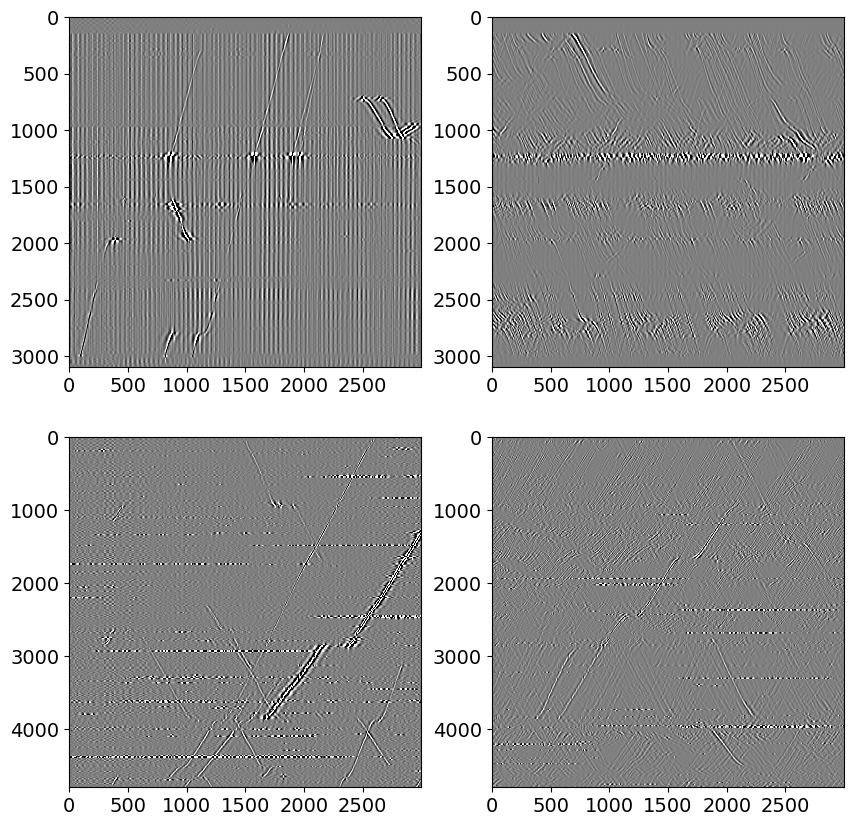

In [79]:
# Load DAS data for visual check 
plt.figure(figsize=(10, 10))
for i, file in enumerate(file_train):
  # Load the data and print basic retrieved parameters
  pdata = np.load(file)['pdata']
  print(file)
  print('Data shape: ', pdata.shape)

  # Plot 
  plt.subplot(2,2, i+1)
  pclip = np.percentile(pdata, 98.)
  plt.imshow(pdata, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)
  
plt.show()


In [83]:
# Setup patch parameters
patch_size = 32
train_ratio = 0.8
shuffle = True
add_noise = True
snr = 10
overlap = True

# Extract image patches (we can join lists together from different files)
input_patches_all = []
ouput_patches_all = []
factors_all = []

for file in file_train[0:1]:
  print('Loading: %s'%(file))

  # Load the data
  pdata = np.load(file)['pdata']

  # Extract patches and normalzation factor
  input_patches, ouput_patches, factors = extract_image_patches(pdata, patch_size, add_noise = add_noise, snr = snr, overlap = overlap)

  # union patches from different data
  input_patches_all += input_patches
  ouput_patches_all += ouput_patches
  factors_all += factors

print("Number of patches: ", len(input_patches_all))

Loading: ./drive/MyDrive/Training Dataset/effective_dataset/smcity_sandhill_nc3100_ch3000-6100_nt3000_sf5_bp0.08-2_D2022-10-25_T10-07-56_p10min.npz
Number of patches:  35712


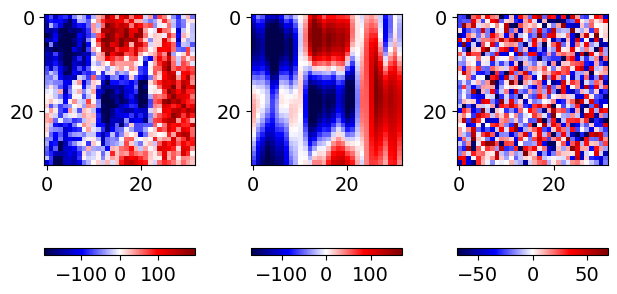

In [84]:
# check the input
idx = 50
for i,data in enumerate([input_patches_all[idx], 
                         ouput_patches_all[idx],
                         input_patches_all[idx] - ouput_patches_all[idx]]):

  pclip = np.percentile(data, 99.)
  plt.subplot(1,3,i+1)
  plt.imshow(data, cmap='seismic', vmin=-pclip, vmax=pclip)
  plt.colorbar(orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
plt.tight_layout()

In [85]:
# Prepare the training and validation dataset
train_dataset, valid_dataset = prepare_das_dataset(input_patches_all, ouput_patches_all, train_ratio = train_ratio, shuffle = shuffle)

# Print info
print('\n')
print('Number of train data: ', len(train_dataset))
print('Number of valid data: ', len(valid_dataset))
print(train_dataset)
print(valid_dataset)



Number of train data:  28569
Number of valid data:  7143
<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>


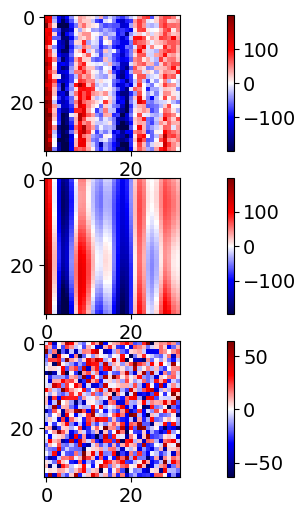

In [86]:
# Check the data visually 
(input, ouput), = valid_dataset.take(1)

plt.figure(figsize=(12,6))

for i,data in enumerate([input, ouput,input - ouput]):
  data  = tf.squeeze(data)
  pclip = np.percentile(data, 99.)
  plt.subplot(3,1,i+1)
  plt.imshow(data, cmap='seismic', vmin=-pclip, vmax=pclip)
  plt.colorbar()

# print(f"Data type: {x.dtype}")
# print(f"Shape: {x.shape}")

## Train the model

In [87]:
trainer, history = train_das_model(
                    train_dataset,             # training dataset
                    valid_dataset,             # validation dataset
                    lmbda=2000,                # weight for rate–distortion Lagrangian
                    latent_dims=100,           # layers in latent space
                    patch_size = patch_size,   # patch size of the image, must be dividable by 4
                    epochs=30,                 # epoch
                    batch_size=128,            # batch size
                    learning_rate=1e-3,        # learning rate
                    validation_freq=1,)        # validation freq
                    

Epoch 1/30
224/224 [==============================] - ETA: 0s - loss: 546.5532 - distortion_loss: 0.1707 - rate_loss: 205.1508 - distortion_pass_through_loss: 0.1706 - rate_pass_through_loss: 205.1198

224/224 [==============================] - 78s 336ms/step - loss: 546.5532 - distortion_loss: 0.1707 - rate_loss: 205.1508 - distortion_pass_through_loss: 0.1706 - rate_pass_through_loss: 205.1198 - val_loss: 471.3095 - val_distortion_loss: 0.1377 - val_rate_loss: 195.9303 - val_distortion_pass_through_loss: 0.1377 - val_rate_pass_through_loss: 195.9319
Epoch 2/30
224/224 [==============================] - 84s 373ms/step - loss: 451.7524 - distortion_loss: 0.1325 - rate_loss: 186.7515 - distortion_pass_through_loss: 0.1325 - rate_pass_through_loss: 186.7231 - val_loss: 437.8439 - val_distortion_loss: 0.1313 - val_rate_loss: 175.2526 - val_distortion_pass_through_loss: 0.1313 - val_rate_pass_through_loss: 175.2540
Epoch 3/30
224/224 [==============================] - 62s 276ms/step - loss: 425.1632 - distortion_loss: 0.1286 - rate_loss: 167.9716 - distortion_pass_through_loss: 0.1286 - rate_pass_through_loss: 167.9413 - val_loss: 414.8567 - val_distortion_loss: 0.1299 - val_rate_loss: 1

In [ ]:
# Save the model if we want
trainer.save_weights("./drive/MyDrive/Training Dataset/das_compression_model_%d"%(patch_size))

In [ ]:
history.history.keys()

dict_keys(['loss', 'distortion_loss', 'rate_loss', 'distortion_pass_through_loss', 'rate_pass_through_loss', 'val_loss', 'val_distortion_loss', 'val_rate_loss', 'val_distortion_pass_through_loss', 'val_rate_pass_through_loss'])

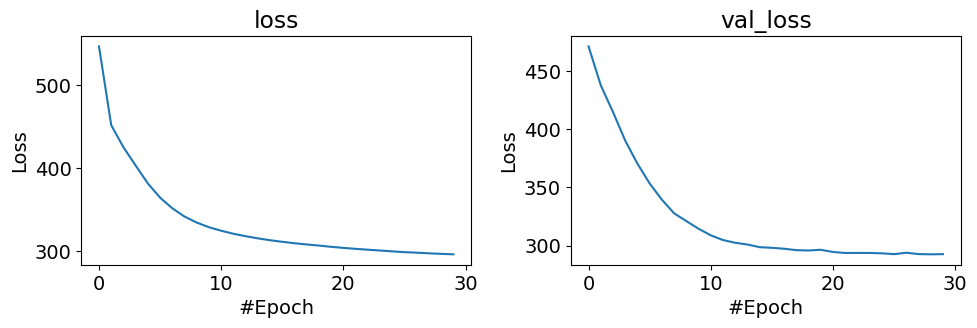

In [88]:
# loss_list = ['loss', 'val_loss', 'rate_loss', 'distortion_loss']

loss_list = ['loss', 'val_loss']

# Plot the rate_loss curve.
plt.figure(figsize=(10,6))
for i, l in enumerate(loss_list):
  plt.subplot(2, 2, i + 1)
  plt.plot(history.history[l])
  plt.xlabel('#Epoch')
  plt.ylabel('Loss')
  plt.title(l)

plt.tight_layout()
plt.savefig('Loss.png', dpi=300, pad_inches=0.1)
plt.show()

## Compress and Decompress on Validation dataset

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [89]:
class DASCompressor(tf.keras.Model):
  """Compresses DAS data to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


class DASDecompressor(tf.keras.Model):
  """Decompresses DAS data from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.float32)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [90]:
def make_das_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.

  entropy_model = tfc.ContinuousBatchedEntropyModel(trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = DASCompressor(trainer.analysis_transform, entropy_model)
  decompressor = DASDecompressor(entropy_model, trainer.synthesis_transform)
  
  return compressor, decompressor

In [91]:
# Setup the trained model 
compressor, decompressor = make_das_codec(trainer)

# Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.
(patch_input, patch_output), = valid_dataset.batch(128).skip(2).take(1)

# Compress them to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(patch_output)

print(f"String representation of first digit in hexadecimal: 0x{strings[1].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[1]:0.2f}")

# Decompress the images back from the strings.
reconstructions = decompressor(strings)


String representation of first digit in hexadecimal: 0xb8d91cc638f0c4
Number of bits actually needed to represent it: 50.40


In [92]:
def display_patch(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 6))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([   
        tf.squeeze(originals[i]),                                # original
        tf.zeros((originals[i].shape[1], 1), tf.float32) - 255,  # boundary 
        tf.squeeze(reconstructions[i]),                          # reconstruction
        tf.zeros((originals[i].shape[1], 1), tf.float32) - 255,  # boundary
        tf.squeeze(originals[i] - reconstructions[i])            # original - reconstruction
        ], 1)
    
    pclip = np.percentile(originals, 99.)
    axes[i].imshow(image, cmap='seismic', vmin=-pclip, vmax=pclip)

    txt = f"{entropies[i]:0.2f} bits"
    # axes[i].set_title(txt)
    # axes[i].axis("off")
    
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.tight_layout()
  plt.savefig('Patch.png', dpi=300, pad_inches=0.1)

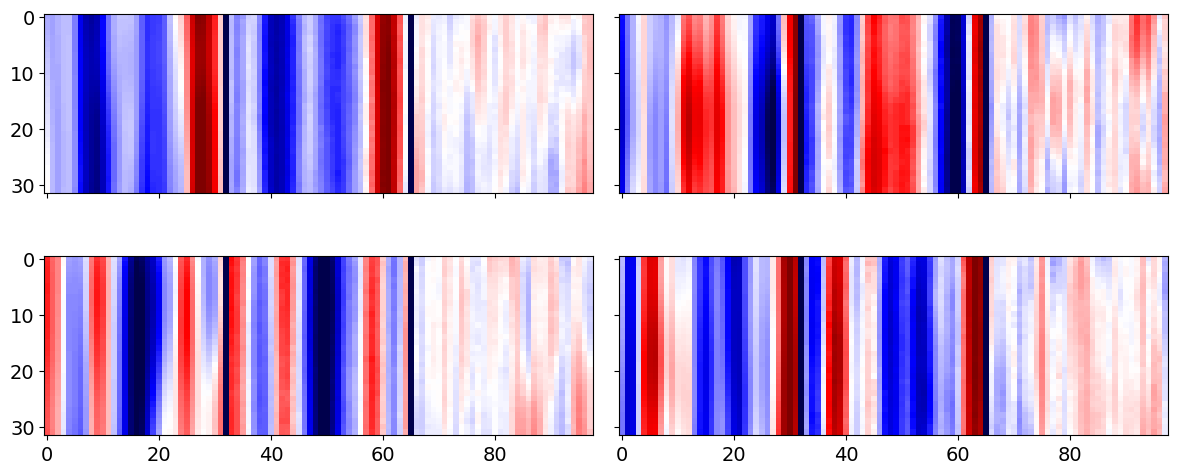

In [93]:
# 4 x 4 plots, for each: (original, reconstruction, original - reconstruction)
display_patch(patch_output, strings, entropies, reconstructions)

## Test the reconstruction for whole DAS section

In [94]:
# Load the original data just from one file
pdata = np.load(file_train[2])['pdata']
patches_original, _, factors = extract_image_patches(pdata, patch_size, add_noise=False)
patches_original = tf.convert_to_tensor(patches_original, dtype=tf.float32)

In [95]:
# Compress them to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(patches_original)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

# Decompress the images back from the strings.
patches_decompre = decompressor(strings)

String representation of first digit in hexadecimal: 0xa9bbcfc5d14545
Number of bits actually needed to represent it: 51.25


In [96]:
# Load the original data just from one file
# Warning: this data has been used in training!! 
# We need to benchmark other data not used in training later.
original_shape = pdata.shape
print('shape of original data: ', original_shape)

original_das = reconstruct_image_from_patches(patches_original, factors, original_shape, patch_size)
decompre_das = reconstruct_image_from_patches(patches_decompre, factors, original_shape, patch_size)

shape of original data:  (4800, 3000)


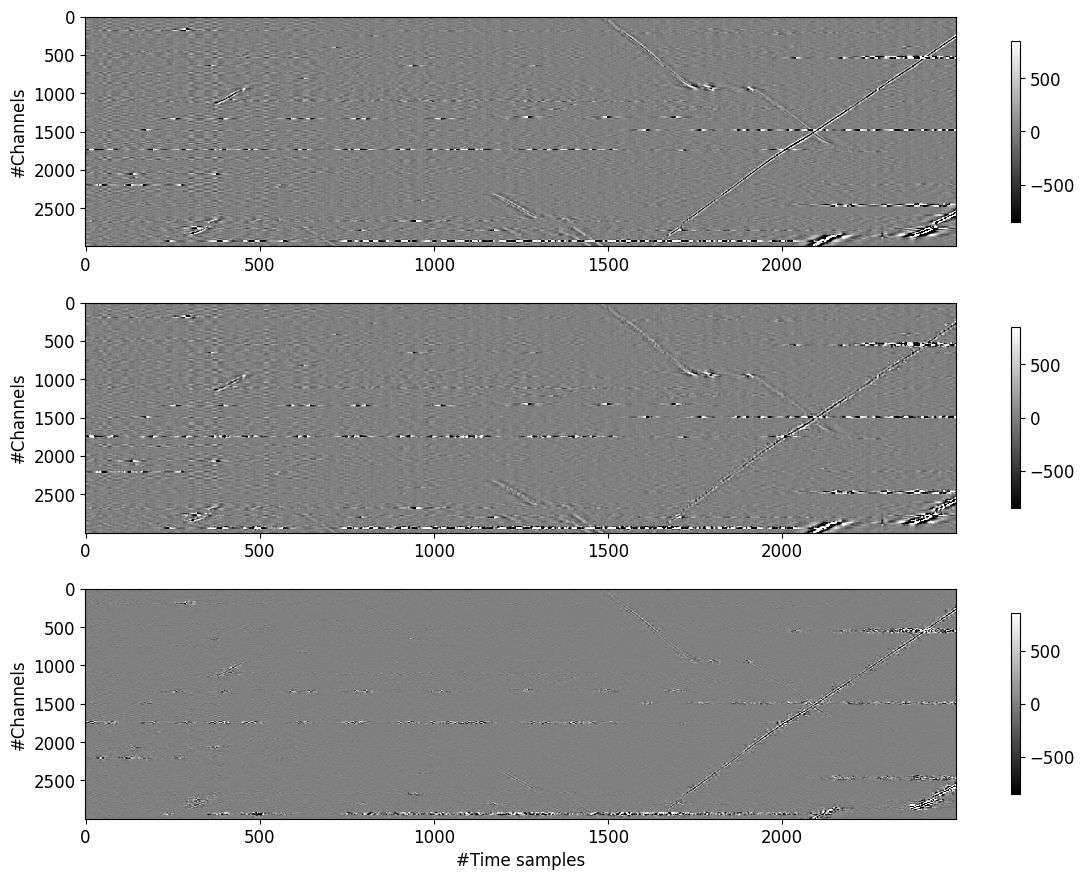

In [97]:
plt.figure(figsize=(12, 9))
plt.rcParams.update({'font.size': 12})
from mpl_toolkits.axes_grid1 import make_axes_locatable

nt = 2500
nc = 3000
aspect = 0.22

relloss = np.sum(np.abs(original_das - decompre_das))/np.sum(np.abs(original_das))
print
plt.subplot(311)
pclip = np.percentile(original_das, 99.)
plt.imshow(original_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Original DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(312)
plt.imshow(decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Reconstructed DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(313)
plt.imshow(original_das[:nc, :nt] - decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Difference')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.tight_layout()
# plt.savefig('./drive/MyDrive/Training Dataset/Final-DAS.png', dpi=300, pad_inches=0.1)

In [ ]:
# # Save the compressed data for stand-alone test
# np.save('./drive/MyDrive/Training Dataset/original_das', original_das)
# np.save('./drive/MyDrive/Training Dataset/decompre_das', decompre_das)
# np.save('./drive/MyDrive/Training Dataset/strings.npy', strings.numpy())
# np.save('./drive/MyDrive/Training Dataset/entropies.npy', entropies.numpy())
# np.save('./drive/MyDrive/Training Dataset/patches_original.npy', patches_original.numpy())
# np.save('./drive/MyDrive/Training Dataset/factors.npy', factors)

In [ ]:
# show the analysis_transform model
trainer.analysis_transform.summary()

# show the model
trainer.synthesis_transform.summary()

# save figures
tf.keras.utils.plot_model(trainer.analysis_transform, to_file='model_analysis_transform.png', show_shapes=True, show_dtype=True)
tf.keras.utils.plot_model(trainer.synthesis_transform, to_file='model_synthesis_transform.png', show_shapes=True, show_dtype=True)